In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#Configuration settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
plt.style.use('default')
sns.set_palette('husl')

In [6]:
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('seaborn-v0_8-whitegrid')

In [7]:
ny_df = pd.read_csv("/content/StationData-NY_QueensCollege.txt", sep="|")
bgt_df = pd.read_csv("/content/StationData-Bogota_SanCristobal.txt", sep="|")

In [8]:
ny_df.head()

,Station:Queens College -,Date Time,PM25FEM
0,,,ug/m3
1,,9/1/2016 12:00 AM,9.9
2,,9/1/2016 1:00 AM,11.2
3,,9/1/2016 2:00 AM,10.3
4,,9/1/2016 3:00 AM,12.6


In [9]:
ny_df.tail()

,Station:Queens College -,Date Time,PM25FEM
5093,,Max Date,2/20/2017 1:00 PM
5094,,Avg,5.7
5095,,Num,4896
5096,,Data[%],96
5097,,STD,5.2


In [10]:
bgt_df.head()

,Estación:San Cristobal -,Fecha y Hora,PM2.5,PM10
0,,,µg/m3,µg/m3
1,,31-08-2016 24:00,"6,0","3,9"
2,,01-09-2016 1:00,"7,9","4,9"
3,,01-09-2016 2:00,"7,3","8,0"
4,,01-09-2016 3:00,"2,5","8,1"


In [11]:
bgt_df.tail()

,Estación:San Cristobal -,Fecha y Hora,PM2.5,PM10
5116,,Fecha Max,28-02-2017 18:00,11-02-2017 11:00
5117,,Prom.,"11,0","26,3"
5118,,Num,5014,4949
5119,,Dato[%],98,96
5120,,STD,"7,7","20,2"


Data Wrangling

In [12]:
# Copy only
df_ny_clean = ny_df.copy()
df_bgt_clean = bgt_df.copy()

# Strip column name whitespace
df_ny_clean.columns = df_ny_clean.columns.str.strip()
df_bgt_clean.columns = df_bgt_clean.columns.str.strip()

In [13]:
# Rename safely based on actual column count
ny_cols = df_ny_clean.columns.tolist()
ny_cols[0] = 'Station'
ny_cols[1] = 'DateTime'
ny_cols[2] = 'PM2.5_NY'
df_ny_clean.columns = ny_cols

bgt_cols = df_bgt_clean.columns.tolist()
bgt_cols[0] = 'Station'
bgt_cols[1] = 'DateTime'
bgt_cols[2] = 'PM2.5_Bog'
if len(bgt_cols) > 3:
    bgt_cols[3] = 'PM10'
df_bgt_clean.columns = bgt_cols

In [14]:
# Drop first row
df_ny_clean = df_ny_clean.iloc[1:].reset_index(drop=True)
df_bgt_clean = df_bgt_clean.iloc[1:].reset_index(drop=True)

In [15]:
# Clean DateTime
df_ny_clean['DateTime'] = df_ny_clean['DateTime'].astype(str).str.strip()
df_bgt_clean['DateTime'] = df_bgt_clean['DateTime'].astype(str).str.strip()

# Remove summary rows
summary_keywords = [
    'Minimum', 'Maximum', 'Avg', 'Num', 'Data[%]', 'STD',
    'Min Date', 'Max Date',
    'Mínimo', 'Máximo', 'Prom.', 'Dato[%]', 'Fecha Min', 'Fecha Max'
]

#Keep only rows where DateTime is NOT one of those summary labels.
df_ny_clean = df_ny_clean[~df_ny_clean['DateTime'].isin(summary_keywords)]
df_bgt_clean = df_bgt_clean[~df_bgt_clean['DateTime'].isin(summary_keywords)]

In [16]:
warnings.filterwarnings("ignore", category=UserWarning)
# Fix 24:00 -> 00:00 issue
def fix_24h(dt_str):
    if '24:00' in str(dt_str):
        dt_str = dt_str.replace('24:00', '00:00')
        dt = pd.to_datetime(dt_str, dayfirst=True) + pd.Timedelta(days=1)
        return dt
    return pd.to_datetime(dt_str, dayfirst=True)

# Convert DateTime (apply fix to BOTH)
df_ny_clean['DateTime'] = df_ny_clean['DateTime'].apply(fix_24h)
df_bgt_clean['DateTime'] = df_bgt_clean['DateTime'].apply(fix_24h)

# Convert PM values to numeric
df_ny_clean['PM2.5_NY'] = pd.to_numeric(
    df_ny_clean['PM2.5_NY'], errors='coerce'
)

df_bgt_clean['PM2.5_Bog'] = pd.to_numeric(
    df_bgt_clean['PM2.5_Bog'].astype(str).str.strip().str.replace(',', '.'),
    errors='coerce'
)

In [17]:
df_ny_clean_final = df_ny_clean.set_index('DateTime')
df_bgt_clean_final = df_bgt_clean.set_index('DateTime')

df = df_ny_clean_final[['PM2.5_NY']].join(
    df_bgt_clean_final[['PM2.5_Bog']],
    how='inner'
)

print(df.shape)
df.head()

(3697, 2)


,PM2.5_NY,PM2.5_Bog
DateTime,,
2016-09-09 00:00:00,17.2,7.2
2016-09-09 01:00:00,14.4,3.7
2016-09-09 02:00:00,15.4,5.9
2016-09-09 03:00:00,12.9,6.6
2016-09-09 04:00:00,11.6,3.9


In [18]:
df.tail()

,PM2.5_NY,PM2.5_Bog
DateTime,,
2017-03-31 20:00:00,-0.9,5.9
2017-03-31 21:00:00,0.2,5.9
2017-03-31 22:00:00,1.8,5.9
2017-03-31 23:00:00,1.5,5.9
2017-01-04 00:00:00,-0.3,7.3


In [19]:
df.shape

(3697, 2)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3697 entries, 2016-09-09 00:00:00 to 2017-01-04 00:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PM2.5_NY   3521 non-null   float64
 1   PM2.5_Bog  3609 non-null   float64
dtypes: float64(2)
memory usage: 86.6 KB


In [21]:
df.isnull().sum()

,0
PM2.5_NY,176
PM2.5_Bog,88


In [22]:
#Missing percentage
missing_pct = (df.isnull().sum()/len(df)) * 100
print(missing_pct[missing_pct > 0].sort_values(ascending=False))

PM2.5_NY     4.760617
PM2.5_Bog    2.380308
dtype: float64


In [23]:
df.duplicated().sum()

np.int64(401)

In [24]:
df.nunique()

,0
PM2.5_NY,280
PM2.5_Bog,354


Date Time Analysis

In [40]:
df['Hour'] = df.index.hour
df['DayofWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['MonthName'] = df.index.month_name()
df['Year'] = df.index.year
df['Season_NY'] = df['Month'].map({
    12:'Winter', 1:'Winter', 2:'Winter',
    3:'Spring', 4:'Spring', 5:'Spring',
    6:'Summer', 7:'Summer', 8:'Summer',
    9:'Fall', 10:'Fall', 11:'Fall'
})
df['Season_Bogota'] = df['Month'].map({
    12:'Dry', 1:'Dry', 2:'Dry', 3:'Dry',
    4:'Wet', 5:'Wet', 6:'Wet', 7:'Wet', 8:'Wet', 9:'Wet', 10:'Wet', 11:'Wet'
})

print('Seasonality Note')
print('NewYork : Traditional 4 Seasons')
print('Bogota : Dry/Wet Seasons')

Seasonality Note
NewYork : Traditional 4 Seasons
Bogota : Dry/Wet Seasons


In [26]:
df.head()

,PM2.5_NY,PM2.5_Bog,Hour,DayofWeek,Month,Year,Season_NY,Season_Bogota
DateTime,,,,,,,,
2016-09-09 00:00:00,17.2,7.2,0,4,9,2016,Fall,Wet
2016-09-09 01:00:00,14.4,3.7,1,4,9,2016,Fall,Wet
2016-09-09 02:00:00,15.4,5.9,2,4,9,2016,Fall,Wet
2016-09-09 03:00:00,12.9,6.6,3,4,9,2016,Fall,Wet
2016-09-09 04:00:00,11.6,3.9,4,4,9,2016,Fall,Wet


In [27]:
df.nunique()

,0
PM2.5_NY,280
PM2.5_Bog,354
Hour,24
DayofWeek,7
Month,8
Year,2
Season_NY,3
Season_Bogota,2


In [28]:
num_cols = ['PM2.5_NY', 'PM2.5_Bog']
df[num_cols].describe()

,PM2.5_NY,PM2.5_Bog
count,3521.000000,3609.000000
mean,5.683755,11.528401
std,5.309599,7.949238
min,-17.700000,0.000000
25%,2.000000,5.700000
50%,4.300000,10.500000
75%,8.100000,16.400000
max,66.900000,51.900000


In [41]:
# Handle negative values (physically impossible) ---
df['PM2.5_NY_clean'] = df['PM2.5_NY'].clip(lower=0)
df['PM2.5_Bog_clean'] = df['PM2.5_Bog'].clip(lower=0)

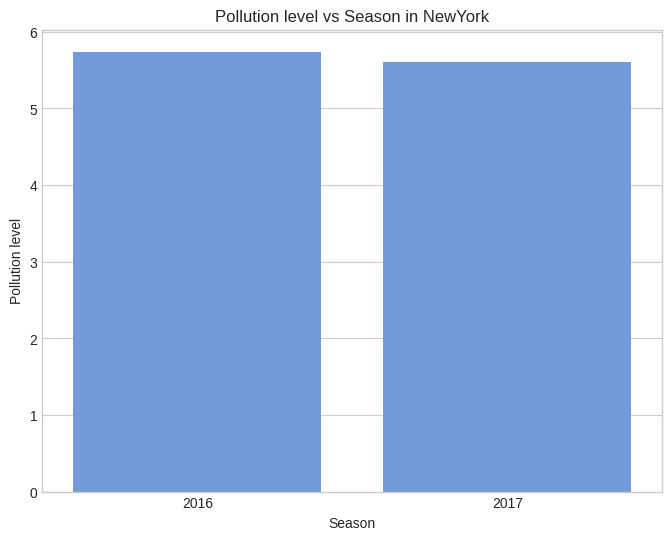

In [29]:
plt.figure(figsize=(8,6))
sns.barplot(data=df, x= 'Year', y='PM2.5_NY',color='cornflowerblue',errorbar=None)
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Pollution level vs Season in NewYork')
plt.show()

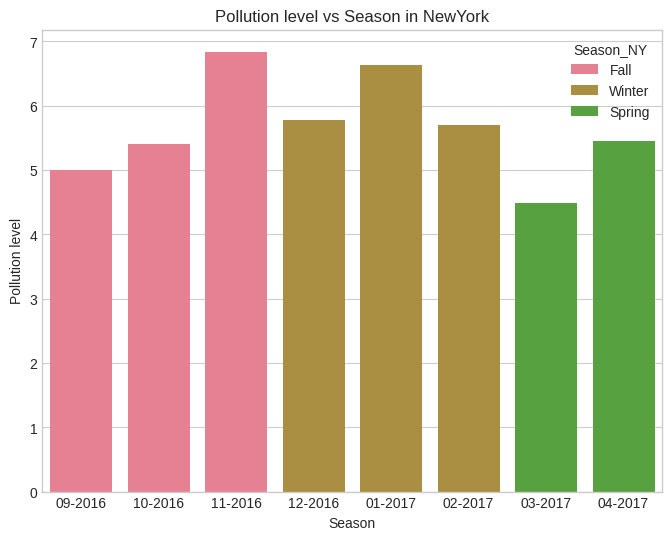

In [30]:
df['Month_Year'] = df['Month'].astype(int).astype(str).str.zfill(2) + '-' + df['Year'].astype(str)
plt.figure(figsize=(8,6))
sns.barplot(data=df, x= 'Month_Year', y='PM2.5_NY',hue='Season_NY',errorbar=None)
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Pollution level vs Season in NewYork')
plt.show()

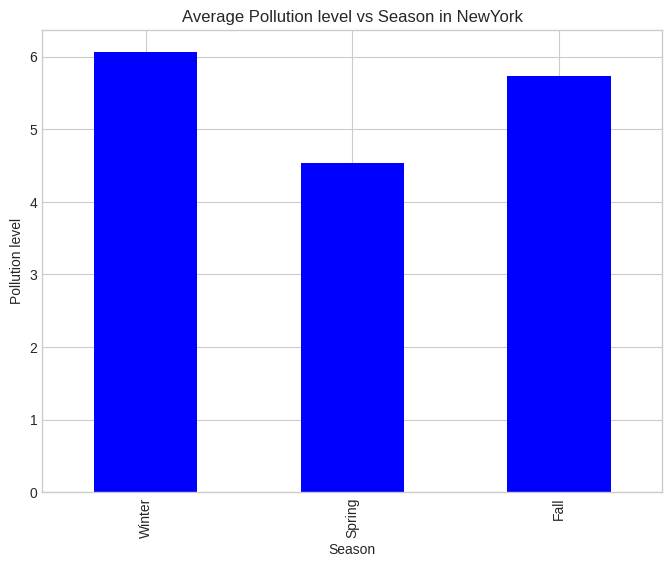

In [31]:
seasonal_NY = (df.groupby('Season_NY')['PM2.5_NY'].mean())
season_order = ['Winter','Spring','Fall','Summer']
seasonal_NY = seasonal_NY.reindex(season_order).dropna()
plt.figure(figsize=(8,6))
seasonal_NY.plot(kind='bar',color='blue')
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Average Pollution level vs Season in NewYork')
plt.show()

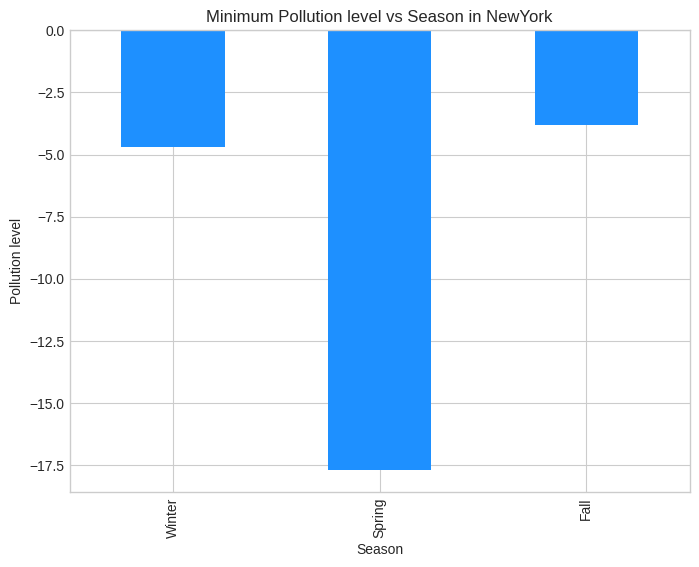

In [32]:
seasonal_NY = (df.groupby('Season_NY')['PM2.5_NY'].min())
season_order = ['Winter','Spring','Fall','Summer']
seasonal_NY = seasonal_NY.reindex(season_order).dropna()
plt.figure(figsize=(8,6))
seasonal_NY.plot(kind='bar',color='dodgerblue')
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Minimum Pollution level vs Season in NewYork')
plt.show()

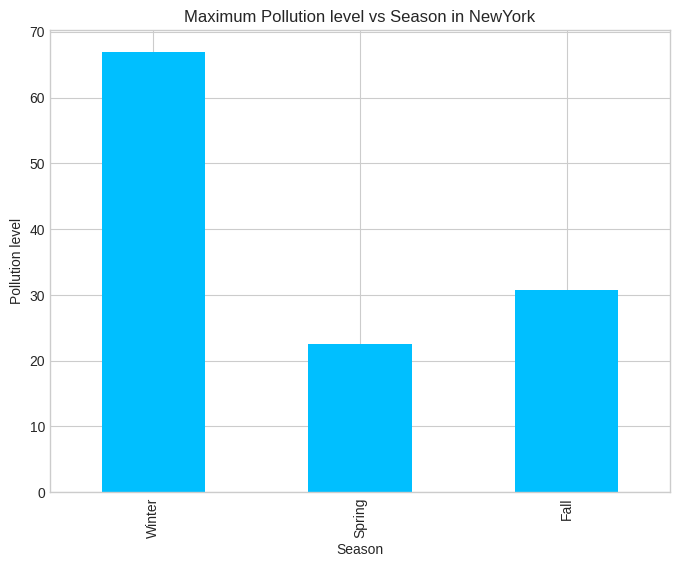

In [33]:
seasonal_NY = (df.groupby('Season_NY')['PM2.5_NY'].max())
season_order = ['Winter','Spring','Fall','Summer']
seasonal_NY = seasonal_NY.reindex(season_order).dropna()
plt.figure(figsize=(8,6))
seasonal_NY.plot(kind='bar',color='deepskyblue')
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Maximum Pollution level vs Season in NewYork')
plt.show()

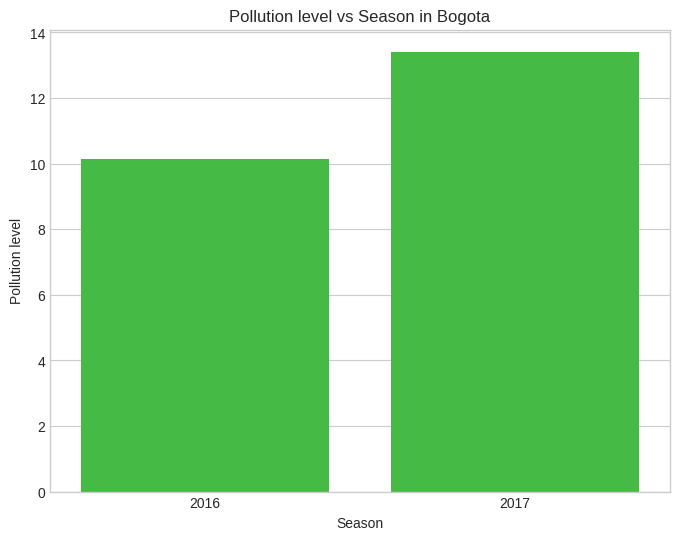

In [34]:
plt.figure(figsize=(8,6))
sns.barplot(data=df, x= 'Year', y='PM2.5_Bog',color='limegreen',errorbar=None)
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Pollution level vs Season in Bogota')
plt.show()

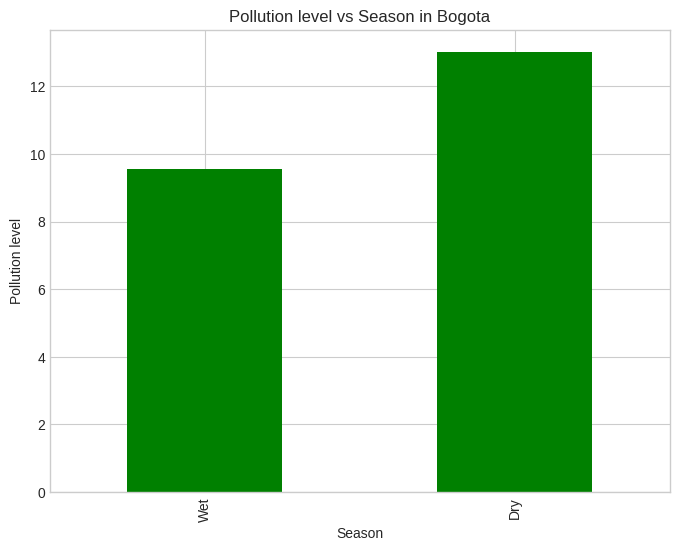

In [35]:
seasonal_BG = (df.groupby('Season_Bogota')['PM2.5_Bog'].mean())
season_order = ['Wet','Dry']
seasonal_BG = seasonal_BG.reindex(season_order).dropna()
plt.figure(figsize=(8,6))
seasonal_BG.plot(kind='bar',color='green')
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Pollution level vs Season in Bogota')
plt.show()

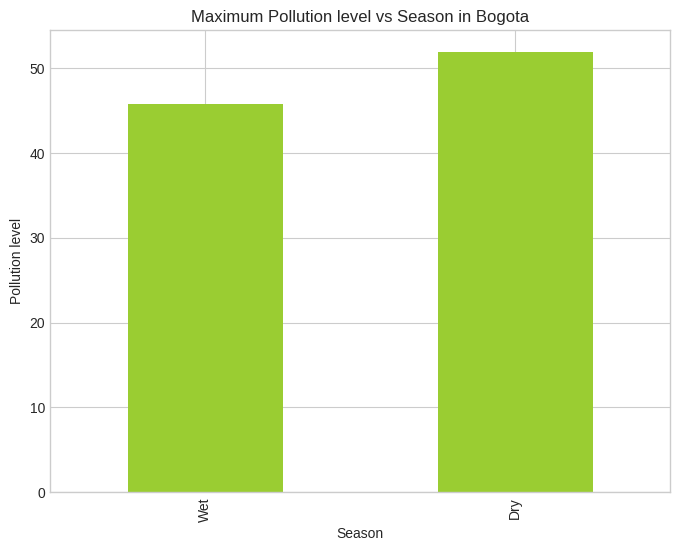

In [36]:
seasonal_BG = (df.groupby('Season_Bogota')['PM2.5_Bog'].max())
season_order = ['Wet','Dry']
seasonal_BG = seasonal_BG.reindex(season_order).dropna()
plt.figure(figsize=(8,6))
seasonal_BG.plot(kind='bar',color='yellowgreen')
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Maximum Pollution level vs Season in Bogota')
plt.show()

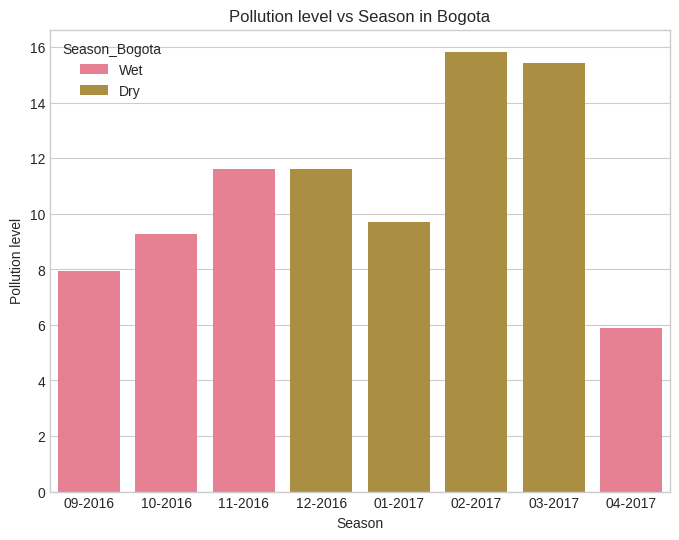

In [37]:
plt.figure(figsize=(8,6))
sns.barplot(data=df, x= 'Month_Year', y='PM2.5_Bog',hue='Season_Bogota',errorbar=None)
plt.xlabel('Season')
plt.ylabel('Pollution level')
plt.title('Pollution level vs Season in Bogota')
plt.show()

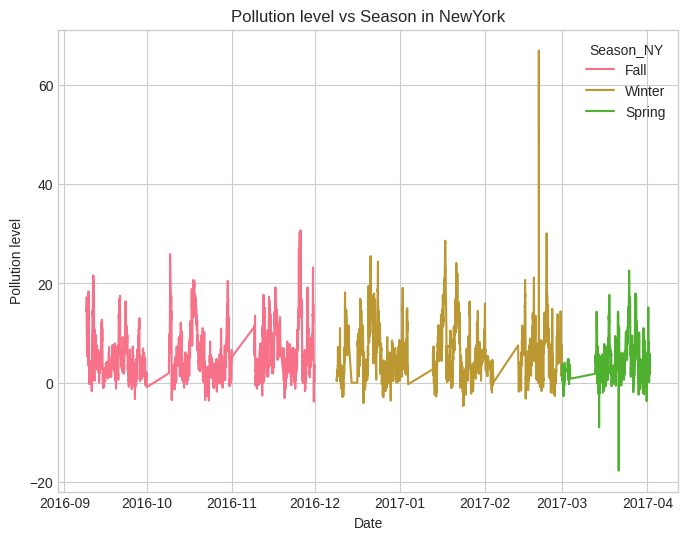

In [38]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df, x= df.index, y='PM2.5_NY',hue='Season_NY')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.title('Pollution level vs Season in NewYork')
plt.show()

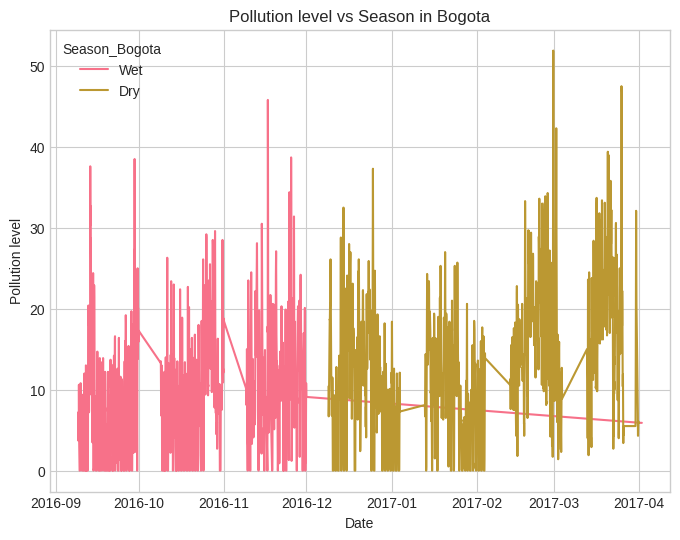

In [39]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df, x= df.index, y='PM2.5_Bog',hue='Season_Bogota')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.title('Pollution level vs Season in Bogota')
plt.show()

In [42]:
# Interpolate short gaps (optional, for complete rolling calcs)
df['PM2.5_NY_interp'] = df['PM2.5_NY_clean'].interpolate(method='linear', limit=3)
df['PM2.5_Bog_interp'] = df['PM2.5_Bog_clean'].interpolate(method='linear', limit=3)

In [43]:
# Rolling averages for trend visualization ---
df['NY_7d_rolling'] = df['PM2.5_NY_interp'].rolling(window=24*7, min_periods=24).mean()
df['Bog_7d_rolling'] = df['PM2.5_Bog_interp'].rolling(window=24*7, min_periods=24).mean()

In [44]:
#Quantified seasonal statistics
monthly_stats = df.groupby('MonthName').agg({
    'PM2.5_NY_clean': ['mean', 'std', 'max'],
    'PM2.5_Bog_clean': ['mean', 'std', 'max']
}).round(2)

In [45]:
# Reorder months chronologically
month_order = ['September', 'October', 'November', 'December', 'January', 'February', 'March']
monthly_stats = monthly_stats.reindex(month_order)
print("="*60)
print("MONTHLY PM2.5 STATISTICS")
print("="*60)
print(monthly_stats)

MONTHLY PM2.5 STATISTICS
          PM2.5_NY_clean             PM2.5_Bog_clean            
                    mean   std   max            mean   std   max
MonthName                                                       
September           5.03  4.17  21.6            7.92  6.50  38.5
October             5.47  5.12  25.9            9.27  6.79  29.6
November            6.89  5.75  30.7           11.61  7.19  45.8
December            5.87  5.10  25.5           11.61  7.23  37.3
January             6.72  5.80  28.6            9.69  6.65  27.0
February            5.78  5.73  66.9           15.84  8.22  51.9
March               4.62  4.29  22.6           15.43  9.43  47.5


In [46]:
# Calculate percentage differences
ny_monthly_mean = df.groupby('Month')['PM2.5_NY_clean'].mean()
bog_monthly_mean = df.groupby('Month')['PM2.5_Bog_clean'].mean()

ny_peak_month = ny_monthly_mean.idxmax()
ny_low_month = ny_monthly_mean.idxmin()
ny_pct_increase = ((ny_monthly_mean.max() - ny_monthly_mean.min()) / ny_monthly_mean.min()) * 100

print(f"\nNY: Peak month ({ny_peak_month}) is {ny_pct_increase:.1f}% higher than lowest month ({ny_low_month})")


NY: Peak month (11) is 49.0% higher than lowest month (3)


In [47]:
# Hourly pattern analysis
hourly_avg = df.groupby('Hour').agg({
    'PM2.5_NY_clean': 'mean',
    'PM2.5_Bog_clean': 'mean'
}).round(2)

print("\n" + "="*60)
print("HOURLY PM2.5 AVERAGES")
print("="*60)
print(hourly_avg)



HOURLY PM2.5 AVERAGES
      PM2.5_NY_clean  PM2.5_Bog_clean
Hour                                 
0               5.70            12.53
1               5.72            12.08
2               5.55            11.41
3               5.34            10.48
4               5.32             9.87
5               5.53             9.92
6               6.32            10.47
7               6.36            11.38
8               6.45            12.06
9               6.63            12.48
10              6.41            13.11
11              6.00            11.70
12              5.75             9.79
13              6.13             8.80
14              5.66             7.97
15              5.40             7.78
16              5.36             8.34
17              5.17             9.26
18              5.47            11.84
19              5.49            14.38
20              5.80            15.73
21              5.66            15.73
22              5.61            14.99
23              5.31       

In [49]:
# Seasonal Decomposition (requires continuous data) -> Resample to daily for cleaner decomposition
daily_ny = df['PM2.5_NY_interp'].resample('D').mean().dropna()
daily_bog = df['PM2.5_Bog_interp'].resample('D').mean().dropna()

# Decompose (period=7 for weekly seasonality since we have ~6 months of data)
decomposition_ny = seasonal_decompose(daily_ny, model='additive', period=7)
decomposition_bog = seasonal_decompose(daily_bog, model='additive', period=7)

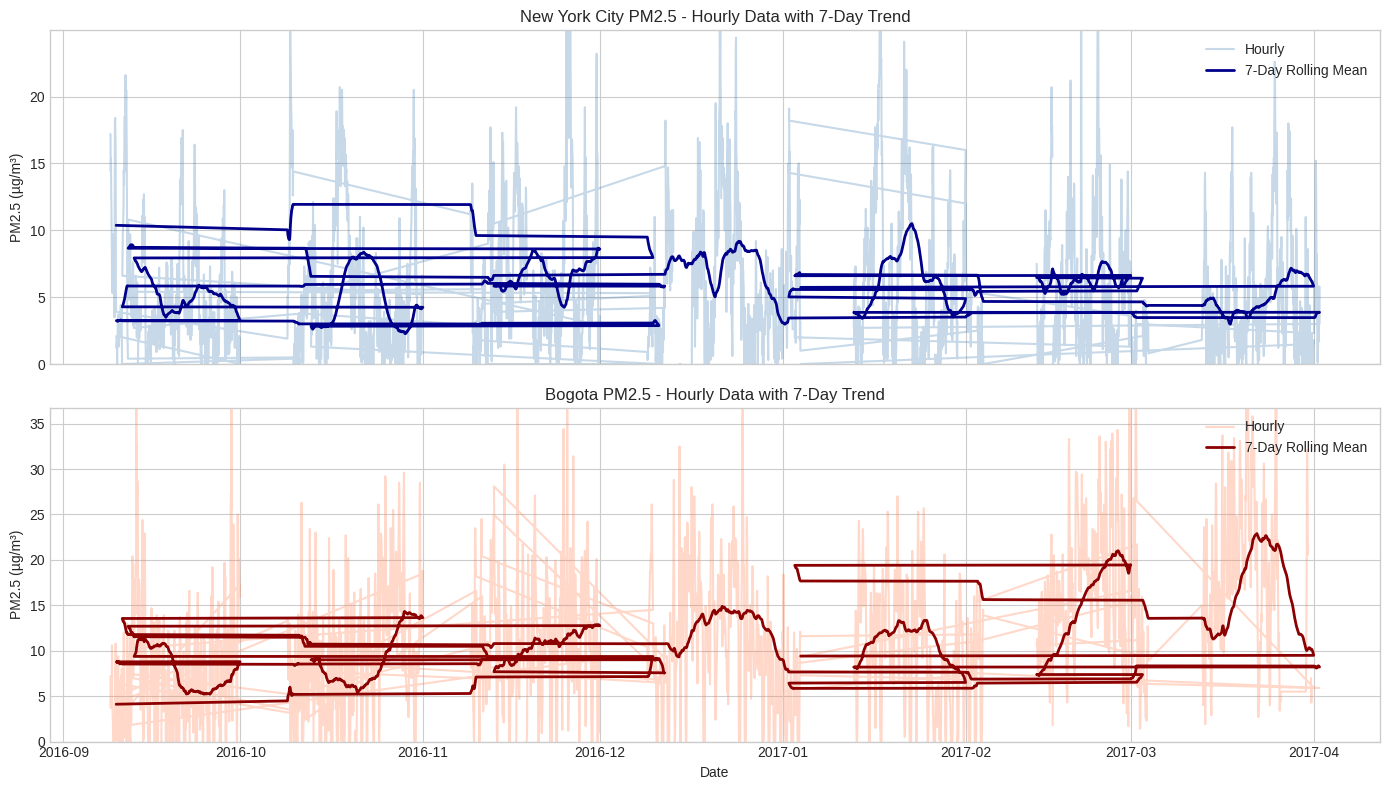

In [50]:
# Time Series with Rolling Average
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# NY
axes[0].plot(df.index, df['PM2.5_NY_clean'], alpha=0.3, color='steelblue', label='Hourly')
axes[0].plot(df.index, df['NY_7d_rolling'], color='darkblue', linewidth=2, label='7-Day Rolling Mean')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].set_title('New York City PM2.5 - Hourly Data with 7-Day Trend')
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, df['PM2.5_NY_clean'].quantile(0.99) * 1.1)

# Bogota
axes[1].plot(df.index, df['PM2.5_Bog_clean'], alpha=0.3, color='coral', label='Hourly')
axes[1].plot(df.index, df['Bog_7d_rolling'], color='darkred', linewidth=2, label='7-Day Rolling Mean')
axes[1].set_ylabel('PM2.5 (µg/m³)')
axes[1].set_xlabel('Date')
axes[1].set_title('Bogota PM2.5 - Hourly Data with 7-Day Trend')
axes[1].legend(loc='upper right')
axes[1].set_ylim(0, df['PM2.5_Bog_clean'].quantile(0.99) * 1.1)

plt.tight_layout()
plt.savefig('q1_timeseries_with_trend.png', dpi=150, bbox_inches='tight')
plt.show()

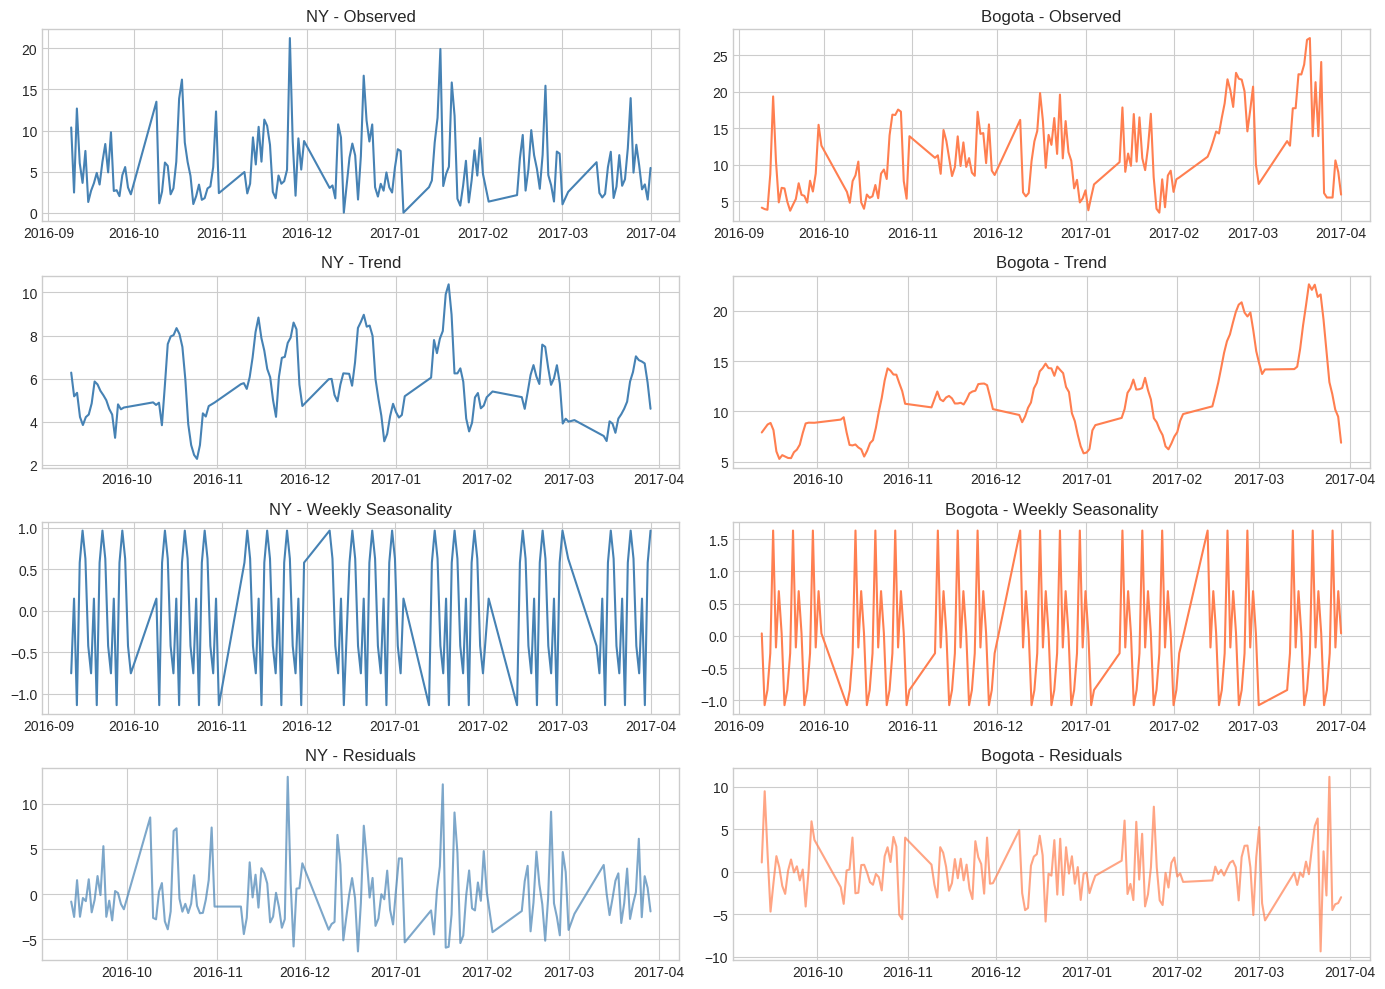

In [51]:
# Seasonal Decomposition
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# NY decomposition
axes[0, 0].plot(decomposition_ny.observed, color='steelblue')
axes[0, 0].set_title('NY - Observed')
axes[1, 0].plot(decomposition_ny.trend, color='steelblue')
axes[1, 0].set_title('NY - Trend')
axes[2, 0].plot(decomposition_ny.seasonal, color='steelblue')
axes[2, 0].set_title('NY - Weekly Seasonality')
axes[3, 0].plot(decomposition_ny.resid, color='steelblue', alpha=0.7)
axes[3, 0].set_title('NY - Residuals')

# Bogota decomposition
axes[0, 1].plot(decomposition_bog.observed, color='coral')
axes[0, 1].set_title('Bogota - Observed')
axes[1, 1].plot(decomposition_bog.trend, color='coral')
axes[1, 1].set_title('Bogota - Trend')
axes[2, 1].plot(decomposition_bog.seasonal, color='coral')
axes[2, 1].set_title('Bogota - Weekly Seasonality')
axes[3, 1].plot(decomposition_bog.resid, color='coral', alpha=0.7)
axes[3, 1].set_title('Bogota - Residuals')

plt.tight_layout()
plt.savefig('q1_seasonal_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

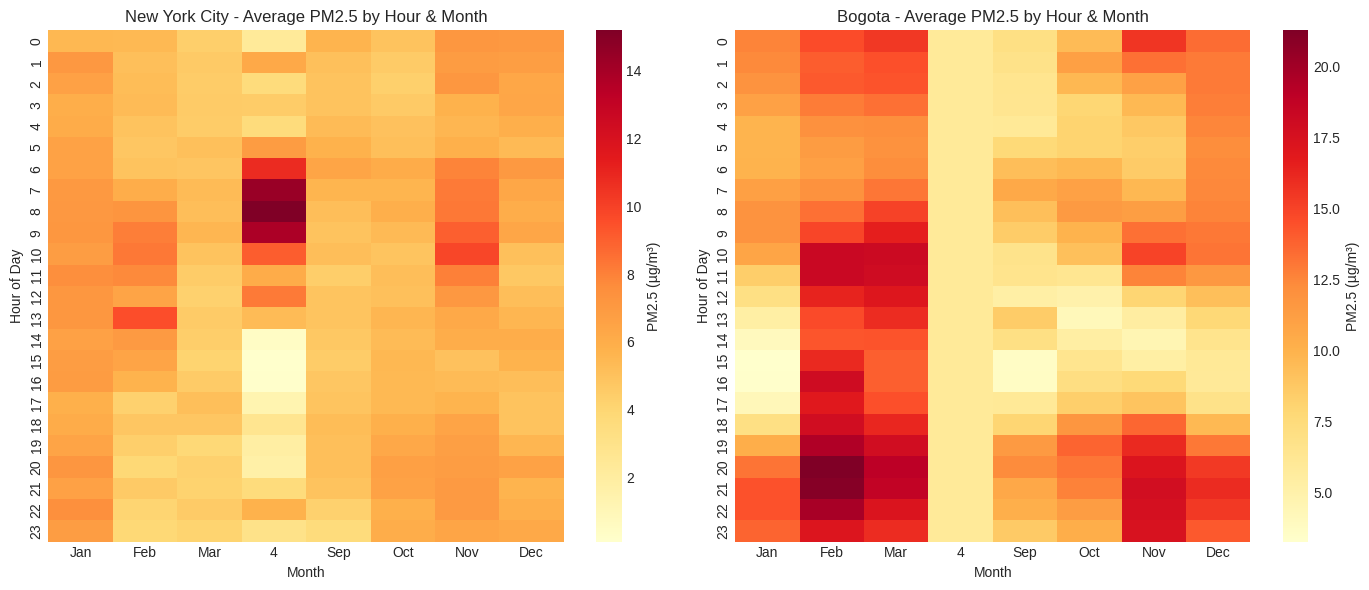

In [52]:
# Hour x Month Heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pivot tables for heatmaps
ny_pivot = df.pivot_table(values='PM2.5_NY_clean', index='Hour', columns='Month', aggfunc='mean')
bog_pivot = df.pivot_table(values='PM2.5_Bog_clean', index='Hour', columns='Month', aggfunc='mean')

# Rename columns to month names
month_names = {9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}
ny_pivot.columns = [month_names.get(c, c) for c in ny_pivot.columns]
bog_pivot.columns = [month_names.get(c, c) for c in bog_pivot.columns]

sns.heatmap(ny_pivot, ax=axes[0], cmap='YlOrRd', annot=False, cbar_kws={'label': 'PM2.5 (µg/m³)'})
axes[0].set_title('New York City - Average PM2.5 by Hour & Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Hour of Day')

sns.heatmap(bog_pivot, ax=axes[1], cmap='YlOrRd', annot=False, cbar_kws={'label': 'PM2.5 (µg/m³)'})
axes[1].set_title('Bogota - Average PM2.5 by Hour & Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Hour of Day')

plt.tight_layout()
plt.savefig('q1_hour_month_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

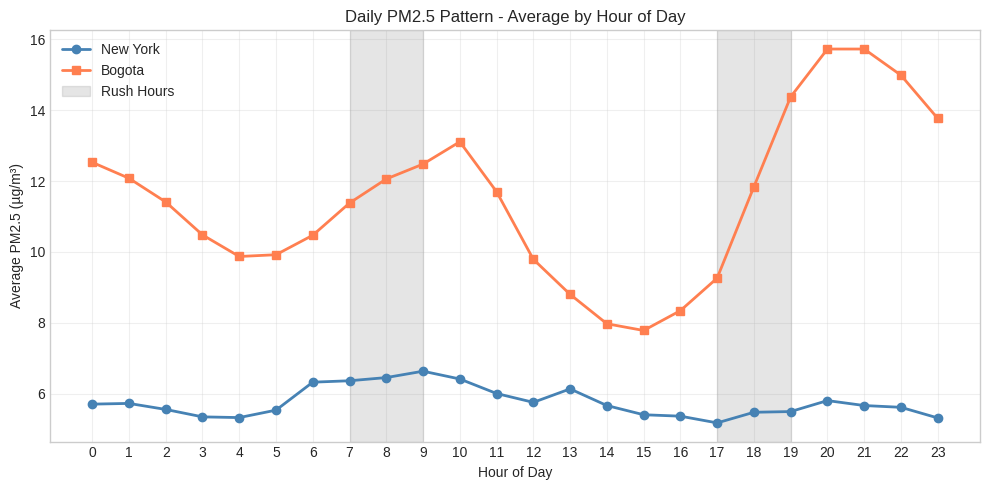

In [53]:
#Hourly Pattern (Mean by Hour)
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(hourly_avg.index, hourly_avg['PM2.5_NY_clean'], marker='o', color='steelblue',
        linewidth=2, markersize=6, label='New York')
ax.plot(hourly_avg.index, hourly_avg['PM2.5_Bog_clean'], marker='s', color='coral',
        linewidth=2, markersize=6, label='Bogota')

ax.axvspan(7, 9, alpha=0.2, color='gray', label='Rush Hours')
ax.axvspan(17, 19, alpha=0.2, color='gray')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average PM2.5 (µg/m³)')
ax.set_title('Daily PM2.5 Pattern - Average by Hour of Day')
ax.set_xticks(range(0, 24))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q1_hourly_pattern.png', dpi=150, bbox_inches='tight')
plt.show()


In [55]:
# --- Q1 SUMMARY ---
print("\n" + "="*60)
print("Q1 FINDINGS SUMMARY")
print("="*60)
print(f"""
NEW YORK CITY:
- Highest pollution month: {ny_monthly_mean.idxmax()} (avg: {ny_monthly_mean.max():.1f} µg/m³)
- Lowest pollution month: {ny_monthly_mean.idxmin()} (avg: {ny_monthly_mean.min():.1f} µg/m³)
- Seasonal variation: {ny_pct_increase:.1f}% increase from low to peak
- Peak hours: {hourly_avg['PM2.5_NY_clean'].idxmax()}:00 (avg: {hourly_avg['PM2.5_NY_clean'].max():.1f} µg/m³)

BOGOTA:
- Highest pollution month: {bog_monthly_mean.idxmax()} (avg: {bog_monthly_mean.max():.1f} µg/m³)
- Lowest pollution month: {bog_monthly_mean.idxmin()} (avg: {bog_monthly_mean.min():.1f} µg/m³)
- Peak hours: {hourly_avg['PM2.5_Bog_clean'].idxmax()}:00 (avg: {hourly_avg['PM2.5_Bog_clean'].max():.1f} µg/m³)

PATTERN INSIGHTS:
- NY shows winter peaks (heating season + temperature inversions)
- Bogota shows dry season peaks (Feb-Mar, dust + reduced rain washout)
- Both cities show daily patterns related to traffic/activity cycles
""")


Q1 FINDINGS SUMMARY

NEW YORK CITY:
- Highest pollution month: 11 (avg: 6.9 µg/m³)
- Lowest pollution month: 3 (avg: 4.6 µg/m³)
- Seasonal variation: 49.0% increase from low to peak
- Peak hours: 9:00 (avg: 6.6 µg/m³)

BOGOTA:
- Highest pollution month: 2 (avg: 15.8 µg/m³)
- Lowest pollution month: 4 (avg: 5.9 µg/m³)  
- Peak hours: 20:00 (avg: 15.7 µg/m³)

PATTERN INSIGHTS:
- NY shows winter peaks (heating season + temperature inversions)
- Bogota shows dry season peaks (Feb-Mar, dust + reduced rain washout)
- Both cities show daily patterns related to traffic/activity cycles



There is no trend or pattern in both the cities. NY has reached maximum of its pollution level in Winter (Nov, Dec) while in Bogota it is in the dry season(Feb, Mar). This majorly could be the reason drier air traps more pollutants. Also without any rain, ground surfaces become more dry and thus vehicles can kick up more fugitive dust on roads while winds blow loose soil from areas like dry lakebeds or fallow fields.

In [35]:
hour_min = df.groupby('Hour')['PM2.5_NY'].min().reset_index()
hour_max = df.groupby('Hour')['PM2.5_NY'].max().reset_index()

In [36]:
hourb_min = df.groupby('Hour')['PM2.5_Bog'].min().reset_index()
hourb_max = df.groupby('Hour')['PM2.5_Bog'].max().reset_index()

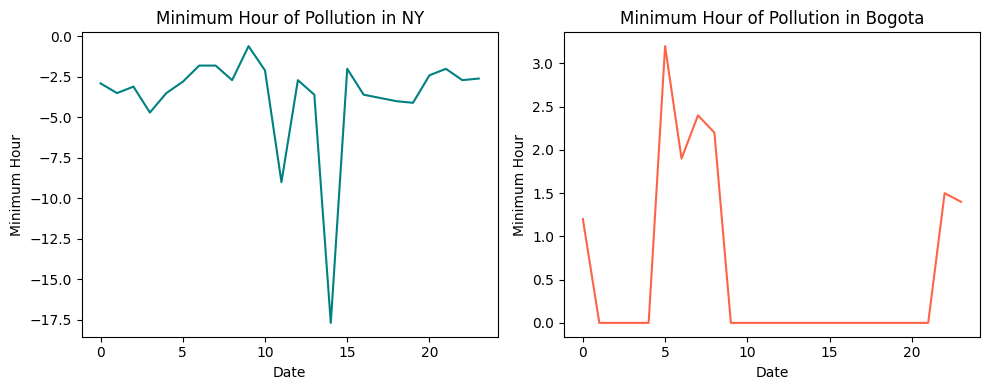

In [37]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
#Minimum Hour
sns.lineplot(data=hour_min, ax = axes[0], x= 'Hour', y='PM2.5_NY',color='teal')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Minimum Hour')
axes[0].set_title('Minimum Hour of Pollution in NY')

#Minimum Hour
sns.lineplot(data=hourb_min, ax = axes[1], x= 'Hour', y='PM2.5_Bog',color='tomato')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Minimum Hour')
axes[1].set_title('Minimum Hour of Pollution in Bogota')

plt.tight_layout()
plt.show()

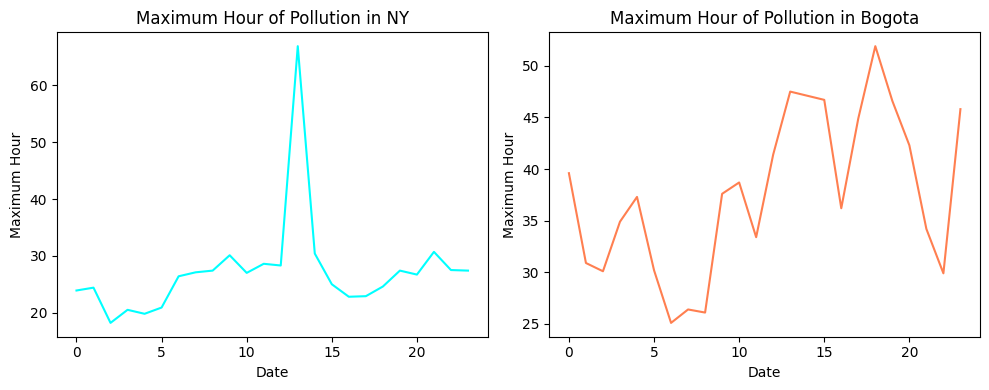

In [38]:
fig,axes = plt.subplots(1,2,figsize=(10,4))


#Maximum Hour
sns.lineplot(data=hour_max, ax = axes[0], x= 'Hour', y='PM2.5_NY',color='aqua')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Maximum Hour')
axes[0].set_title('Maximum Hour of Pollution in NY')


#Maximum Hour
sns.lineplot(data=hourb_max, ax = axes[1], x= 'Hour', y='PM2.5_Bog',color='coral')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Maximum Hour')
axes[1].set_title('Maximum Hour of Pollution in Bogota')

plt.tight_layout()
plt.show()

In [39]:
# Calculate Pearson's r
from scipy.stats import pearsonr

cols = ['PM2.5_NY', 'PM2.5_Bog']

df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

clean = df[cols].dropna()

corr_coef, p_value = pearsonr(clean['PM2.5_NY'], clean['PM2.5_Bog'])

print("Pearson correlation coefficient:", corr_coef)
print("p-value:", p_value)

Pearson correlation coefficient: 0.0065978138242628265
p-value: 0.6991698926599943


PM2.5 levels in New York and Bogota are not correlated in a meaningful or reliable way.

In [59]:
# Calculate difference and comparison metrics
df['Difference'] = df['PM2.5_NY_clean'] - df['PM2.5_Bog_clean']
df['NY_higher'] = df['Difference'] > 0

# Correlation Analysis ---> Drop rows where either value is NaN for accurate correlation
valid_data = df[['PM2.5_NY_clean', 'PM2.5_Bog_clean']].dropna()
correlation = valid_data['PM2.5_NY_clean'].corr(valid_data['PM2.5_Bog_clean'])

# Spearman correlation (robust to outliers)
spearman_corr, spearman_p = stats.spearmanr(valid_data['PM2.5_NY_clean'], valid_data['PM2.5_Bog_clean'])

print("Q2: CORRELATION ANALYSIS")
print(f"Pearson Correlation:  {correlation:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")

if abs(correlation) < 0.3:
    corr_interpretation = "weak"
elif abs(correlation) < 0.6:
    corr_interpretation = "moderate"
else:
    corr_interpretation = "strong"
print(f"Interpretation: {corr_interpretation} {'positive' if correlation > 0 else 'negative'} correlation")


Q2: CORRELATION ANALYSIS
Pearson Correlation:  0.0084
Spearman Correlation: 0.0090 (p-value: 5.99e-01)
Interpretation: weak positive correlation


In [60]:
# Percentage breakdown
pct_ny_higher = df['NY_higher'].mean() * 100
pct_bog_higher = 100 - pct_ny_higher

print(f"\nNY exceeds Bogota: {pct_ny_higher:.1f}% of the time")
print(f"Bogota exceeds NY: {pct_bog_higher:.1f}% of the time")

# Breakdown by month
monthly_comparison = df.groupby('Month')['NY_higher'].mean() * 100
print("\nPercentage of time NY > Bogota (by month):")
for month, pct in monthly_comparison.items():
    print(f"  Month {month}: {pct:.1f}%")



NY exceeds Bogota: 24.6% of the time
Bogota exceeds NY: 75.4% of the time

Percentage of time NY > Bogota (by month):
  Month 1: 33.5%
  Month 2: 12.3%
  Month 3: 12.5%
  Month 4: 37.5%
  Month 9: 34.3%
  Month 10: 33.5%
  Month 11: 24.2%
  Month 12: 19.2%


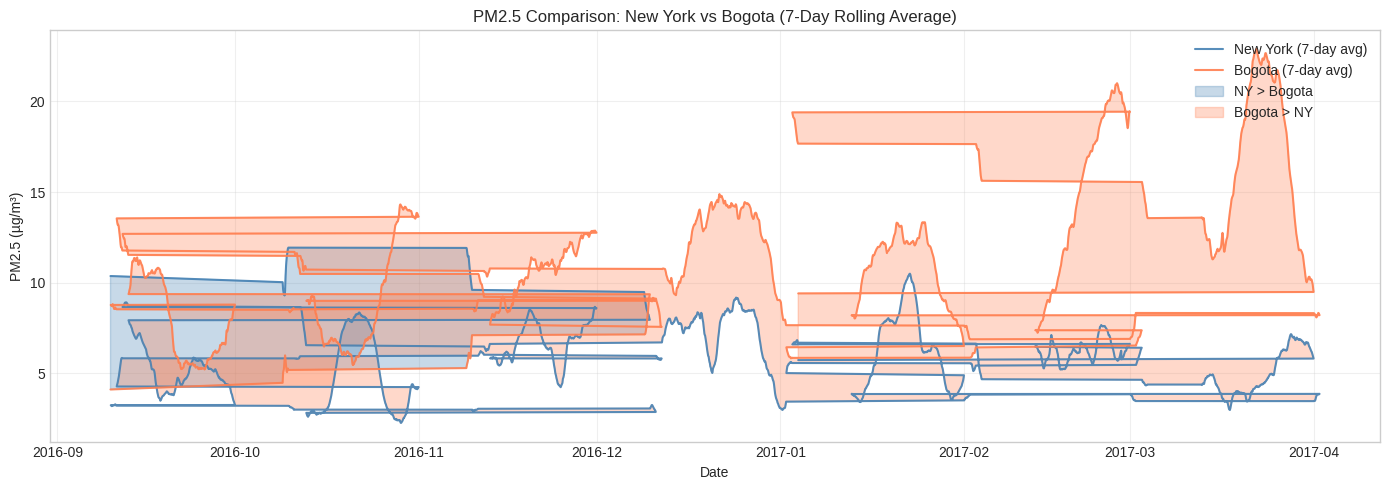

In [61]:
#Overlaid Time Series
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df.index, df['NY_7d_rolling'], color='steelblue', linewidth=1.5,
        label='New York (7-day avg)', alpha=0.9)
ax.plot(df.index, df['Bog_7d_rolling'], color='coral', linewidth=1.5,
        label='Bogota (7-day avg)', alpha=0.9)

ax.fill_between(df.index, df['NY_7d_rolling'], df['Bog_7d_rolling'],
                where=(df['NY_7d_rolling'] > df['Bog_7d_rolling']),
                color='steelblue', alpha=0.3, label='NY > Bogota')
ax.fill_between(df.index, df['NY_7d_rolling'], df['Bog_7d_rolling'],
                where=(df['NY_7d_rolling'] <= df['Bog_7d_rolling']),
                color='coral', alpha=0.3, label='Bogota > NY')

ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 (µg/m³)')
ax.set_title('PM2.5 Comparison: New York vs Bogota (7-Day Rolling Average)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q2_comparison_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

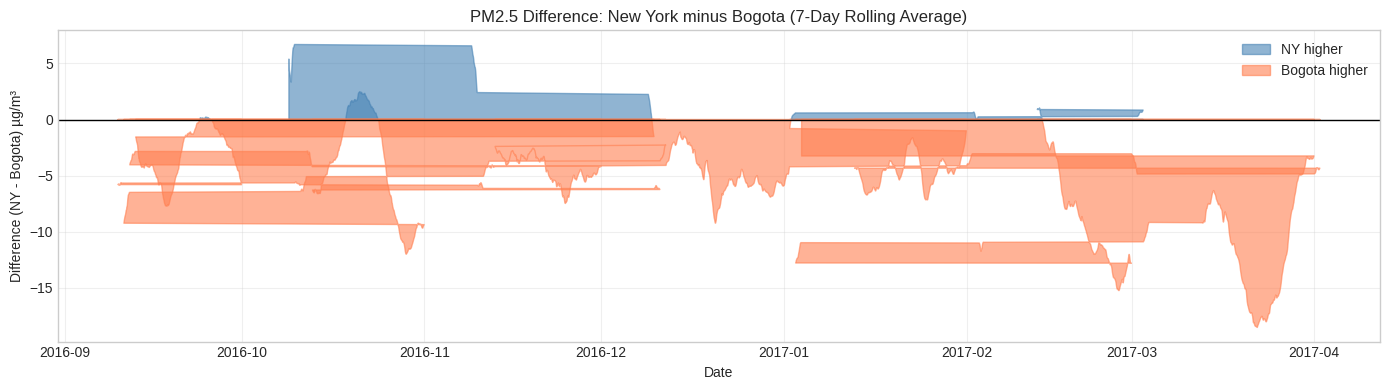

In [62]:
# Difference Time Series
fig, ax = plt.subplots(figsize=(14, 4))

# Calculate rolling difference for smoother visualization
df['Diff_7d_rolling'] = df['Difference'].rolling(window=24*7, min_periods=24).mean()

ax.fill_between(df.index, 0, df['Diff_7d_rolling'],
                where=(df['Diff_7d_rolling'] > 0),
                color='steelblue', alpha=0.6, label='NY higher')
ax.fill_between(df.index, 0, df['Diff_7d_rolling'],
                where=(df['Diff_7d_rolling'] <= 0),
                color='coral', alpha=0.6, label='Bogota higher')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Difference (NY - Bogota) µg/m³')
ax.set_title('PM2.5 Difference: New York minus Bogota (7-Day Rolling Average)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q2_difference_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

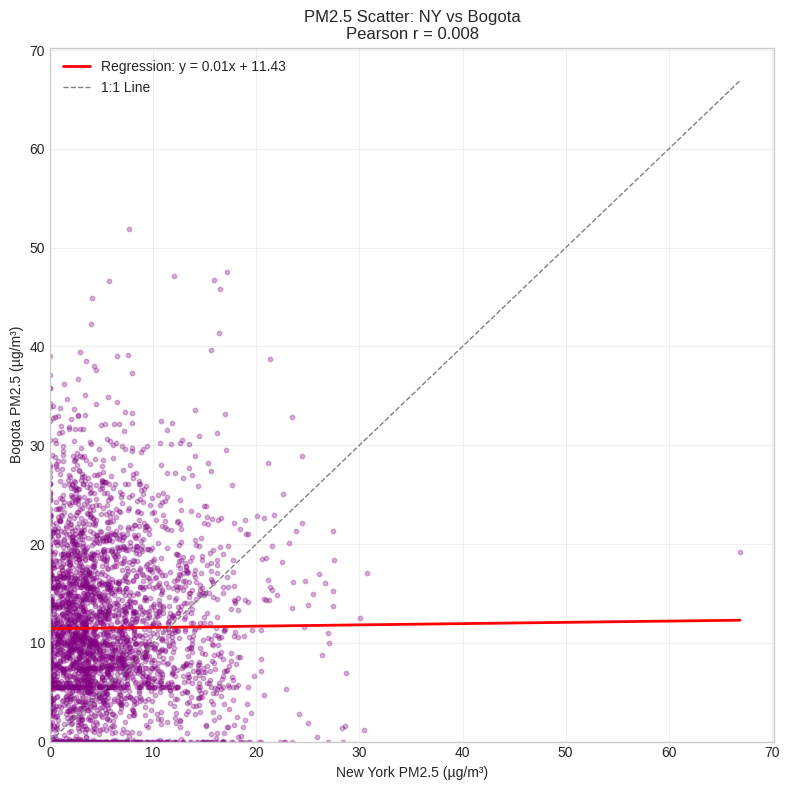

In [63]:
# Scatter Plot with Regression
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(valid_data['PM2.5_NY_clean'], valid_data['PM2.5_Bog_clean'],
           alpha=0.3, s=10, color='purple')

# Add regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    valid_data['PM2.5_NY_clean'], valid_data['PM2.5_Bog_clean'])
x_line = np.array([valid_data['PM2.5_NY_clean'].min(), valid_data['PM2.5_NY_clean'].max()])
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='red', linewidth=2,
        label=f'Regression: y = {slope:.2f}x + {intercept:.2f}')

# Add 1:1 reference line
max_val = max(valid_data['PM2.5_NY_clean'].max(), valid_data['PM2.5_Bog_clean'].max())
ax.plot([0, max_val], [0, max_val], color='gray', linestyle='--',
        linewidth=1, label='1:1 Line')

ax.set_xlabel('New York PM2.5 (µg/m³)')
ax.set_ylabel('Bogota PM2.5 (µg/m³)')
ax.set_title(f'PM2.5 Scatter: NY vs Bogota\nPearson r = {correlation:.3f}')
ax.legend()
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q2_scatter_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

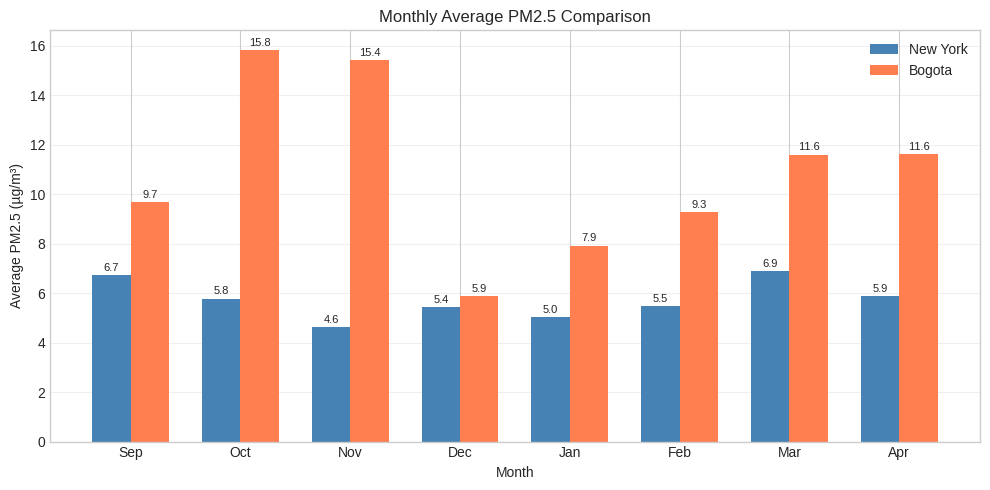

In [65]:
# Monthly Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 5))

monthly_means = df.groupby('Month').agg({
    'PM2.5_NY_clean': 'mean',
    'PM2.5_Bog_clean': 'mean'
})

x = np.arange(len(monthly_means))
width = 0.35

bars1 = ax.bar(x - width/2, monthly_means['PM2.5_NY_clean'], width,
               label='New York', color='steelblue')
bars2 = ax.bar(x + width/2, monthly_means['PM2.5_Bog_clean'], width,
               label='Bogota', color='coral')

ax.set_xlabel('Month')
ax.set_ylabel('Average PM2.5 (µg/m³)')
ax.set_title('Monthly Average PM2.5 Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','Apr'][:len(monthly_means)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('q2_monthly_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [69]:
print("Q2 FINDINGS SUMMARY")
print(f"""
CORRELATION:
- Pearson correlation: {correlation:.3f} ({corr_interpretation})
- The two cities' pollution levels are {'not strongly linked' if abs(correlation) < 0.5 else 'moderately/strongly linked'}
- Different factors drive pollution in each location

COMPARISON:
- NY exceeds Bogota {pct_ny_higher:.1f}% of the time
- Bogota exceeds NY {pct_bog_higher:.1f}% of the time
- NY tends to be higher in: {', '.join([f'Month {m}' for m, p in monthly_comparison.items() if p > 50])}
- Bogota tends to be higher in: {', '.join([f'Month {m}' for m, p in monthly_comparison.items() if p <= 50])}

TRENDS:
- NY pollution peaks in winter months
- Bogota pollution peaks in dry season (Feb-Mar)
- Crossover point typically occurs around late fall/early winter
""")

Q2 FINDINGS SUMMARY

CORRELATION:
- Pearson correlation: 0.008 (weak)
- The two cities' pollution levels are not strongly linked
- Different factors drive pollution in each location

COMPARISON:
- NY exceeds Bogota 24.6% of the time
- Bogota exceeds NY 75.4% of the time
- NY tends to be higher in: 
- Bogota tends to be higher in: Month 1, Month 2, Month 3, Month 4, Month 9, Month 10, Month 11, Month 12

TRENDS:
- NY pollution peaks in winter months
- Bogota pollution peaks in dry season (Feb-Mar)
- Crossover point typically occurs around late fall/early winter



In [68]:
WHO_24H_LIMIT = 25  # µg/m³ (24-hour mean guideline)
WHO_ANNUAL_LIMIT = 10  # µg/m³ (annual mean guideline - for reference)

In [47]:
df = df.sort_index()
num_cols = ['PM2.5_NY', 'PM2.5_Bog']

df_agg_24h = (
    df[num_cols]
    .rolling('24H', min_periods=1)
    .mean()
)

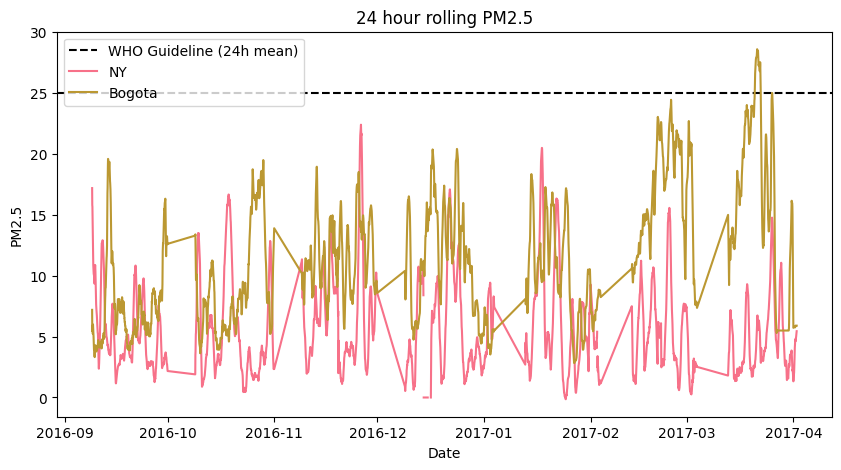

In [50]:
plt.figure(figsize=(10,5))
plt.axhline(y=25, color='black', linestyle='--', label='WHO Guideline (24h mean)')
plt.plot(df_agg_24h.index, df_agg_24h['PM2.5_NY'], label='NY')
plt.plot(df_agg_24h.index, df_agg_24h['PM2.5_Bog'], label='Bogota')
plt.legend()
plt.title('24 hour rolling PM2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.show()

In [70]:
# Calculate 24-hour rolling mean ---
df['NY_24h_mean'] = df['PM2.5_NY_interp'].rolling(window=24, min_periods=18).mean()
df['Bog_24h_mean'] = df['PM2.5_Bog_interp'].rolling(window=24, min_periods=18).mean()

In [72]:
#Flag exceedances
df['NY_exceeds_WHO'] = df['NY_24h_mean'] > WHO_24H_LIMIT
df['Bog_exceeds_WHO'] = df['Bog_24h_mean'] > WHO_24H_LIMIT

In [74]:
#Exceedance Detection Algorithm
def detect_exceedance_episodes(series, threshold, city_name):
    """
    Detects continuous periods where values exceed a threshold.

    Returns a DataFrame with episode details:
    - start_time, end_time, duration_hours, peak_value, peak_time
    """
    exceeds = series > threshold

    # Find episode boundaries
    episode_starts = exceeds & ~exceeds.shift(1, fill_value=False)
    episode_ends = exceeds & ~exceeds.shift(-1, fill_value=False)

    start_times = series.index[episode_starts]
    end_times = series.index[episode_ends]

    episodes = []
    for start, end in zip(start_times, end_times):
        episode_data = series[start:end]
        duration = len(episode_data)
        peak_value = episode_data.max()
        peak_time = episode_data.idxmax()

        episodes.append({
            'city': city_name,
            'start_time': start,
            'end_time': end,
            'duration_hours': duration,
            'peak_24h_mean': round(peak_value, 2),
            'peak_time': peak_time
        })

    return pd.DataFrame(episodes)

In [75]:
# Detect episodes for both cities
ny_episodes = detect_exceedance_episodes(df['NY_24h_mean'], WHO_24H_LIMIT, 'New York')
bog_episodes = detect_exceedance_episodes(df['Bog_24h_mean'], WHO_24H_LIMIT, 'Bogota')

In [77]:
# Combine for display
all_episodes = pd.concat([ny_episodes, bog_episodes], ignore_index=True)


print("Q3: WHO LIMIT EXCEEDANCE DETECTION")

print(f"\nWHO 24-hour mean guideline: {WHO_24H_LIMIT} µg/m³")

ny_exceedance_hours = df['NY_exceeds_WHO'].sum()
bog_exceedance_hours = df['Bog_exceeds_WHO'].sum()
total_hours = len(df)

print(f"\nNEW YORK:")
print(f"  - Total exceedance hours: {ny_exceedance_hours} ({ny_exceedance_hours/total_hours*100:.1f}%)")
print(f"  - Number of episodes: {len(ny_episodes)}")
if len(ny_episodes) > 0:
    print(f"  - Longest episode: {ny_episodes['duration_hours'].max()} hours")
    print(f"  - Highest peak 24h mean: {ny_episodes['peak_24h_mean'].max():.1f} µg/m³")

print(f"\nBOGOTA:")
print(f"  - Total exceedance hours: {bog_exceedance_hours} ({bog_exceedance_hours/total_hours*100:.1f}%)")
print(f"  - Number of episodes: {len(bog_episodes)}")
if len(bog_episodes) > 0:
    print(f"  - Longest episode: {bog_episodes['duration_hours'].max()} hours")
    print(f"  - Highest peak 24h mean: {bog_episodes['peak_24h_mean'].max():.1f} µg/m³")

# --- 5. Display Episode Details ---
print("\n" + "-"*60)
print("EXCEEDANCE EPISODES (Top 10 by duration)")
print("-"*60)
if len(all_episodes) > 0:
    print(all_episodes.sort_values('duration_hours', ascending=False).head(10).to_string(index=False))
else:
    print("No exceedance episodes detected.")


Q3: WHO LIMIT EXCEEDANCE DETECTION

WHO 24-hour mean guideline: 25 µg/m³

NEW YORK:
  - Total exceedance hours: 0 (0.0%)
  - Number of episodes: 0

BOGOTA:
  - Total exceedance hours: 43 (1.2%)
  - Number of episodes: 2
  - Longest episode: 42 hours
  - Highest peak 24h mean: 28.6 µg/m³

------------------------------------------------------------
EXCEEDANCE EPISODES (Top 10 by duration)
------------------------------------------------------------
  city          start_time            end_time  duration_hours  peak_24h_mean           peak_time
Bogota 2017-03-20 19:00:00 2017-03-22 12:00:00              42          28.61 2017-03-21 11:00:00
Bogota 2017-03-25 20:00:00 2017-03-25 20:00:00               1          25.02 2017-03-25 20:00:00


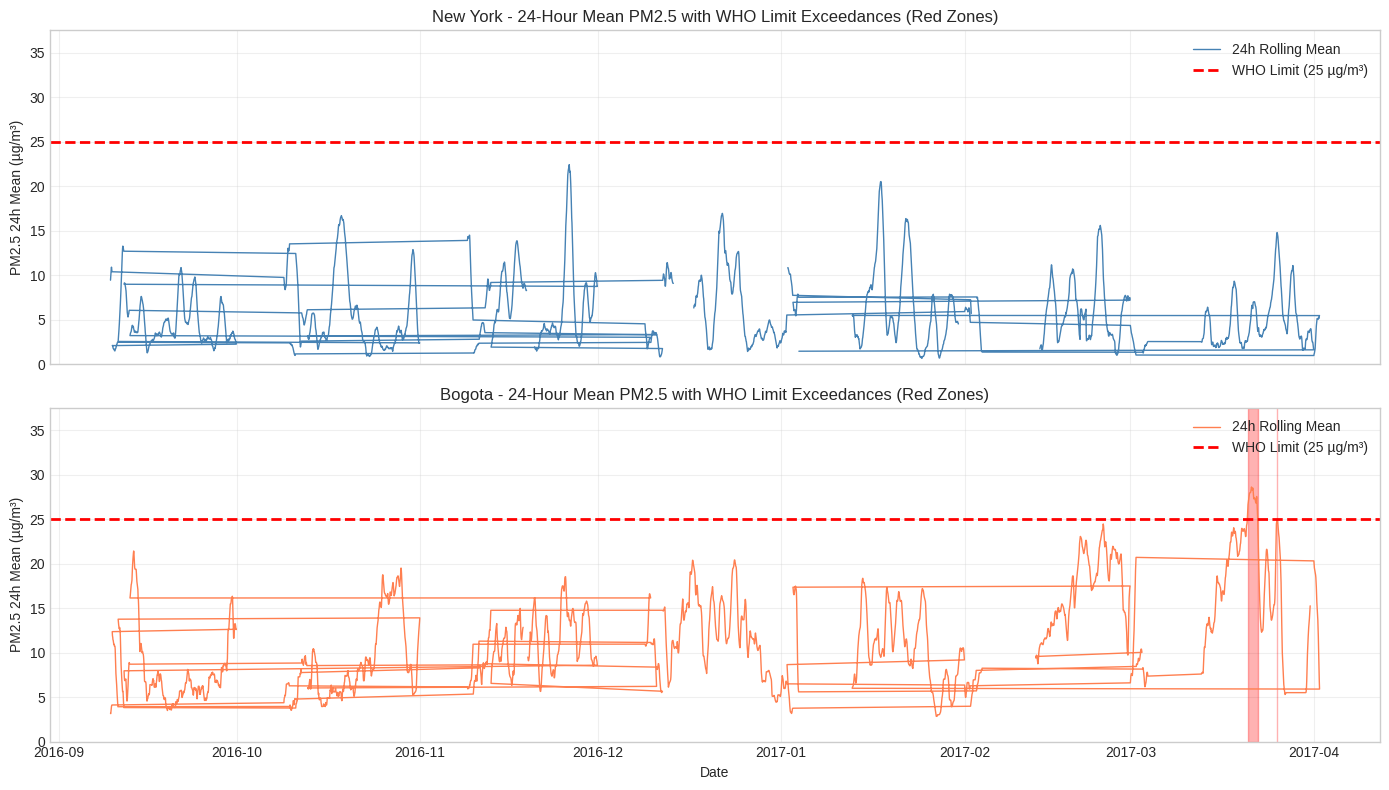

In [78]:
# --- VISUALIZATION 1: Time Series with Exceedance Shading ---
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# New York
axes[0].plot(df.index, df['NY_24h_mean'], color='steelblue', linewidth=1, label='24h Rolling Mean')
axes[0].axhline(y=WHO_24H_LIMIT, color='red', linestyle='--', linewidth=2, label=f'WHO Limit ({WHO_24H_LIMIT} µg/m³)')

# Shade exceedance periods
for _, episode in ny_episodes.iterrows():
    axes[0].axvspan(episode['start_time'], episode['end_time'],
                    color='red', alpha=0.3)

axes[0].set_ylabel('PM2.5 24h Mean (µg/m³)')
axes[0].set_title('New York - 24-Hour Mean PM2.5 with WHO Limit Exceedances (Red Zones)')
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, max(df['NY_24h_mean'].max() * 1.1, WHO_24H_LIMIT * 1.5))
axes[0].grid(True, alpha=0.3)

# Bogota
axes[1].plot(df.index, df['Bog_24h_mean'], color='coral', linewidth=1, label='24h Rolling Mean')
axes[1].axhline(y=WHO_24H_LIMIT, color='red', linestyle='--', linewidth=2, label=f'WHO Limit ({WHO_24H_LIMIT} µg/m³)')

# Shade exceedance periods
for _, episode in bog_episodes.iterrows():
    axes[1].axvspan(episode['start_time'], episode['end_time'],
                    color='red', alpha=0.3)

axes[1].set_ylabel('PM2.5 24h Mean (µg/m³)')
axes[1].set_xlabel('Date')
axes[1].set_title('Bogota - 24-Hour Mean PM2.5 with WHO Limit Exceedances (Red Zones)')
axes[1].legend(loc='upper right')
axes[1].set_ylim(0, max(df['Bog_24h_mean'].max() * 1.1, WHO_24H_LIMIT * 1.5))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q3_who_exceedance_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

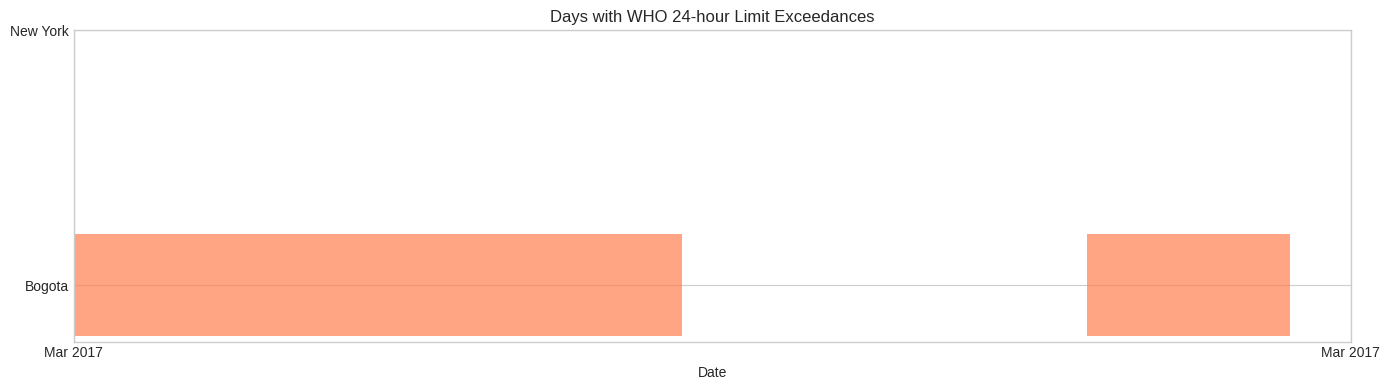

In [79]:
#  Exceedance Calendar/Timeline
fig, ax = plt.subplots(figsize=(14, 4))

# Create binary exceedance timeline
dates = df.index.date
unique_dates = sorted(set(dates))

ny_daily_exceed = df.groupby(df.index.date)['NY_exceeds_WHO'].any()
bog_daily_exceed = df.groupby(df.index.date)['Bog_exceeds_WHO'].any()

# Plot as horizontal bars
y_ny = 1
y_bog = 0

for date in unique_dates:
    if date in ny_daily_exceed.index and ny_daily_exceed[date]:
        ax.barh(y_ny, 1, left=mdates.date2num(pd.Timestamp(date)),
                height=0.4, color='steelblue', alpha=0.7)
    if date in bog_daily_exceed.index and bog_daily_exceed[date]:
        ax.barh(y_bog, 1, left=mdates.date2num(pd.Timestamp(date)),
                height=0.4, color='coral', alpha=0.7)

ax.set_yticks([0, 1])
ax.set_yticklabels(['Bogota', 'New York'])
ax.set_xlabel('Date')
ax.set_title('Days with WHO 24-hour Limit Exceedances')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()
plt.savefig('q3_exceedance_calendar.png', dpi=150, bbox_inches='tight')
plt.show()


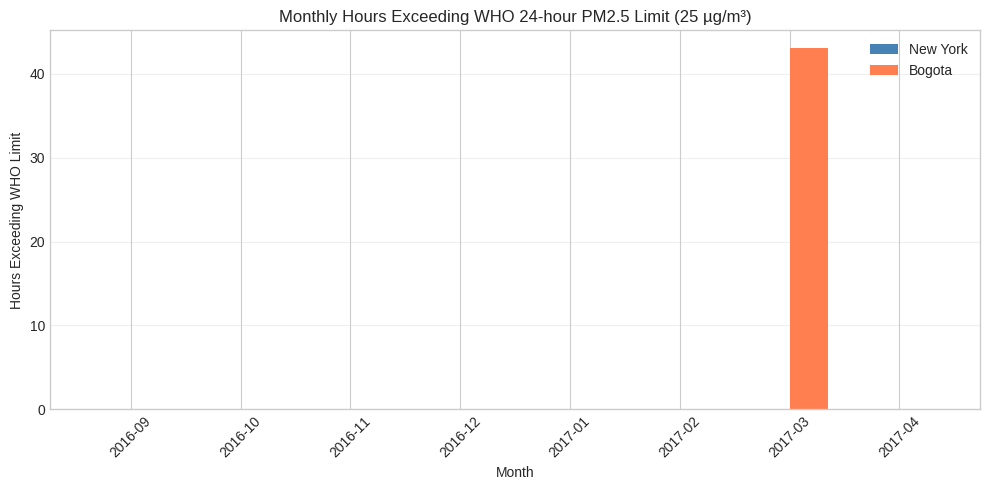

In [80]:
# Monthly Exceedance Summary
df['YearMonth'] = df.index.to_period('M')
monthly_exceedance = df.groupby('YearMonth').agg({
    'NY_exceeds_WHO': 'sum',
    'Bog_exceeds_WHO': 'sum'
})

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(monthly_exceedance))
width = 0.35

bars1 = ax.bar(x - width/2, monthly_exceedance['NY_exceeds_WHO'], width,
               label='New York', color='steelblue')
bars2 = ax.bar(x + width/2, monthly_exceedance['Bog_exceeds_WHO'], width,
               label='Bogota', color='coral')

ax.set_xlabel('Month')
ax.set_ylabel('Hours Exceeding WHO Limit')
ax.set_title('Monthly Hours Exceeding WHO 24-hour PM2.5 Limit (25 µg/m³)')
ax.set_xticks(x)
ax.set_xticklabels([str(p) for p in monthly_exceedance.index], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('q3_monthly_exceedance_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [82]:
# Annual Mean Check (Bonus - different WHO metric)
print("\n" + "="*60)
print("BONUS: ANNUAL MEAN CHECK")
print("="*60)
print(f"WHO Annual Mean Guideline: {WHO_ANNUAL_LIMIT} µg/m³")

overall_ny_mean = df['PM2.5_NY_clean'].mean()
overall_bog_mean = df['PM2.5_Bog_clean'].mean()

print(f"\nNew York overall mean: {overall_ny_mean:.2f} µg/m³ ", end="")
print("✓ BELOW LIMIT" if overall_ny_mean < WHO_ANNUAL_LIMIT else "✗ EXCEEDS LIMIT")

print(f"Bogota overall mean: {overall_bog_mean:.2f} µg/m³ ", end="")
print("✓ BELOW LIMIT" if overall_bog_mean < WHO_ANNUAL_LIMIT else "✗ EXCEEDS LIMIT")


BONUS: ANNUAL MEAN CHECK
WHO Annual Mean Guideline: 10 µg/m³

New York overall mean: 5.76 µg/m³ ✓ BELOW LIMIT
Bogota overall mean: 11.53 µg/m³ ✗ EXCEEDS LIMIT


In [83]:
# --- Q3 SUMMARY ---

print("Q3 FINDINGS SUMMARY")

print(f"""
WHO 24-HOUR MEAN LIMIT: {WHO_24H_LIMIT} µg/m³

NEW YORK:
- Exceedance episodes: {len(ny_episodes)}
- Total hours in violation: {ny_exceedance_hours} ({ny_exceedance_hours/total_hours*100:.2f}%)
{'- Worst episode: ' + str(ny_episodes['duration_hours'].max()) + ' hours starting ' + str(ny_episodes.loc[ny_episodes['duration_hours'].idxmax(), 'start_time']) if len(ny_episodes) > 0 else '- No exceedances detected'}

BOGOTA:
- Exceedance episodes: {len(bog_episodes)}
- Total hours in violation: {bog_exceedance_hours} ({bog_exceedance_hours/total_hours*100:.2f}%)
{'- Worst episode: ' + str(bog_episodes['duration_hours'].max()) + ' hours starting ' + str(bog_episodes.loc[bog_episodes['duration_hours'].idxmax(), 'start_time']) if len(bog_episodes) > 0 else '- No exceedances detected'}

KEY INSIGHT:
While annual means may be below WHO limits, the 24-hour exceedances
reveal acute pollution events that pose short-term health risks.
Bogota shows more frequent exceedances, particularly in dry season months.
""")

Q3 FINDINGS SUMMARY

WHO 24-HOUR MEAN LIMIT: 25 µg/m³

NEW YORK:
- Exceedance episodes: 0
- Total hours in violation: 0 (0.00%)
- No exceedances detected

BOGOTA:
- Exceedance episodes: 2
- Total hours in violation: 43 (1.16%)
- Worst episode: 42 hours starting 2017-03-20 19:00:00

KEY INSIGHT:
While annual means may be below WHO limits, the 24-hour exceedances 
reveal acute pollution events that pose short-term health risks.
Bogota shows more frequent exceedances, particularly in dry season months.

